<a href="https://colab.research.google.com/github/YasminaNasser/Hate_Speech_Detection/blob/main/Deep_Learning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hate Speech Detection using Deep Learning

**Ain Shams University - Faculty of Engineering**  
**CSE485 Deep Learning: Major Task**

---

## Project Overview

This project implements a Deep Learning model to detect hate speech in tweets using LSTM (Long Short-Term Memory) networks. The dataset contains tweets classified into three categories:

- **0 - Hate Speech**: Content explicitly targeting individuals or groups with harmful intent
- **1 - Offensive Language**: Content containing offensive language but not necessarily hate speech  
- **2 - Neither**: Neutral content without any offensive or hateful intent

## Objectives

1. Explore and visualize the dataset
2. Preprocess textual data (stopwords, punctuation removal, lemmatization)
3. Build and train an LSTM model
4. Evaluate model performance
5. Analyze results comprehensively

## 1. Import Required Libraries


In [1]:
# ============================================================
# 📦 INSTALL ALL REQUIRED PACKAGES
# ============================================================
# Run this cell FIRST if you're setting up for the first time!
# This installs all necessary packages for the entire notebook.

%pip install pandas numpy matplotlib seaborn -q
%pip install nltk tensorflow scikit-learn -q
%pip install imbalanced-learn wordcloud contractions -q

print("✅ All packages installed successfully!")
print("\n📋 Installed packages:")
print("  • pandas, numpy - Data manipulation")
print("  • matplotlib, seaborn - Visualization")
print("  • nltk - Natural Language Processing")
print("  • tensorflow - Deep Learning (LSTM model)")
print("  • scikit-learn - ML utilities & metrics")
print("  • imbalanced-learn - SMOTE for class balancing")
print("  • wordcloud - Word cloud visualizations")
print("  • contractions - Contraction expansion (200+ mappings)")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.2 MB/s eta 0:00:00
✅ All packages installed successfully!

📋 Installed packages:
  • pandas, numpy - Data manipulation
  • matplotlib, seaborn - Visualization
  • nltk - Natural Language Processing
  • tensorflow - Deep Learning (LSTM model)
  • scikit-learn - ML utilities & metrics
  • imbalanced-learn - SMOTE for class balancing
  • wordcloud - Word cloud visualizations
  • contractions - Contraction expansion (200+ mappings)


In [2]:
# Mount Google Drive (optional for saving outputs)
from google.colab import drive
drive.mount('/content/drive')

print("Setup complete!")

Mounted at /content/drive
Setup complete!


In [9]:
# imports
import pandas as pd
!pip install gdown -q
import gdown
import matplotlib.pyplot as plt
import numpy as np

# Download from Google Drive
file_id = '1tn2X9JtOjqG7PKTZLUEy8sJS0r_WV7Qf'
url = f'https://drive.google.com/uc?id={file_id}'
gdown.download(url, 'hate_speech.csv', quiet=False)

# Load dataset
df = pd.read_csv('hate_speech.csv')
print("✓ Dataset loaded!")
print(f"Shape: {df.shape}")
print(df['class'].value_counts().sort_index())
df.head()

Downloading...
From: https://drive.google.com/uc?id=1tn2X9JtOjqG7PKTZLUEy8sJS0r_WV7Qf
To: /content/hate_speech.csv
100%|██████████| 2.21M/2.21M [00:00<00:00, 140MB/s]

✓ Dataset loaded!
Shape: (24783, 2)
class
0     1430
1    19190
2     4163
Name: count, dtype: int64


,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [10]:
# Basic dataset information
print("Dataset Information:")
print(df.info())
print("\n" + "="*50)
print("\nBasic Statistics:")
print(df.describe())
print("\n" + "="*50)
print("\nMissing Values:")
print(df.isnull().sum())
print("\n" + "="*50)
print("\nDuplicate Rows:")
print(f"Number of duplicate rows: {df.duplicated().sum()}")

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   24783 non-null  int64 
 1   tweet   24783 non-null  object
dtypes: int64(1), object(1)
memory usage: 387.4+ KB
None


Basic Statistics:
              class
count  24783.000000
mean       1.110277
std        0.462089
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000


Missing Values:
class    0
tweet    0
dtype: int64


Duplicate Rows:
Number of duplicate rows: 0


## 3. Data Visualization and Class Distribution

In [11]:
# Class distribution
class_counts = df['class'].value_counts().sort_index()
print("Class Distribution:")
print(class_counts)
print("\n" + "="*50)
print("\nClass Distribution (Percentage):")
print(df['class'].value_counts(normalize=True).sort_index() * 100)

# Create labels for classes
class_labels = {
    0: 'Hate Speech',
    1: 'Offensive Language',
    2: 'Neither'
}

Class Distribution:
class
0     1430
1    19190
2     4163
Name: count, dtype: int64


Class Distribution (Percentage):
class
0     5.770084
1    77.432111
2    16.797805
Name: proportion, dtype: float64


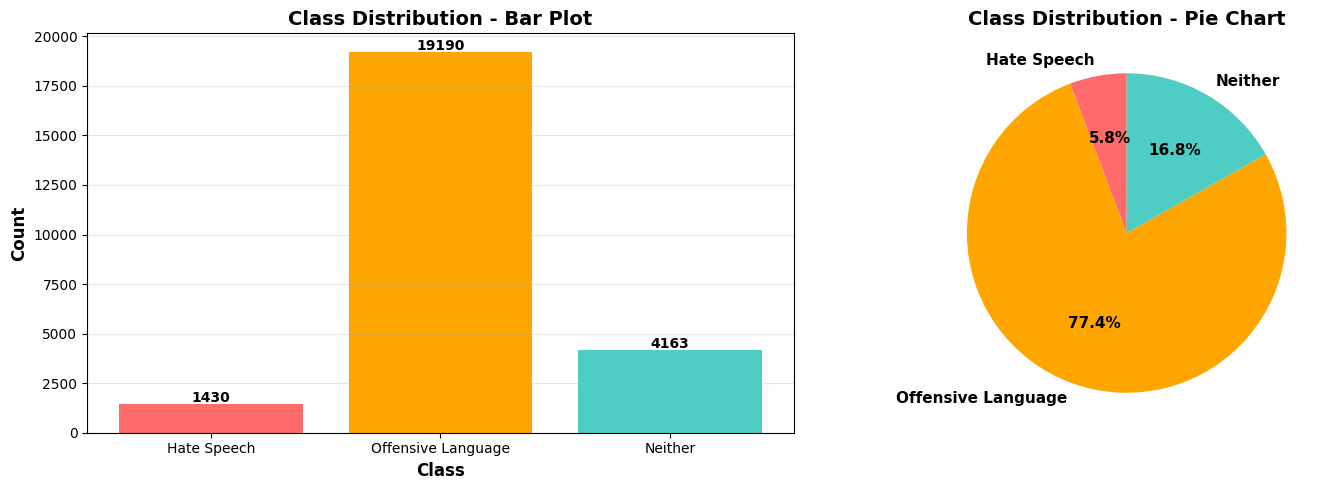

In [12]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot
class_counts_labeled = class_counts.rename(class_labels)
axes[0].bar(class_counts_labeled.index, class_counts_labeled.values, color=['#FF6B6B', '#FFA500', '#4ECDC4'])
axes[0].set_xlabel('Class', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[0].set_title('Class Distribution - Bar Plot', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(class_counts_labeled.values):
    axes[0].text(i, v + 100, str(v), ha='center', fontweight='bold')

# Pie chart
colors = ['#FF6B6B', '#FFA500', '#4ECDC4']
axes[1].pie(class_counts.values, labels=[class_labels[i] for i in class_counts.index],
            autopct='%1.1f%%', colors=colors, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[1].set_title('Class Distribution - Pie Chart', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

#### 📌 Key Findings: Class Distribution

**Critical Observations:**
1. **Severe Class Imbalance Detected:**
   - Offensive Language dominates with **77.4%** (19,190 tweets)
   - Neither class: **16.8%** (4,163 tweets)
   - Hate Speech is severely underrepresented: **5.8%** (1,430 tweets)

2. **Imbalance Ratio:** The largest class (Offensive) is **13.4x larger** than the smallest (Hate Speech)

**Implications for Model Training:**
- ⚠️ Standard accuracy metrics will be misleading (model could predict "Offensive" for everything and get 77% accuracy)
- ✅ **Solution:** We will use **class weights** to penalize misclassification of minority classes
- ✅ **Evaluation:** Focus on **F1-score per class** and **macro-averaged metrics** rather than accuracy alone

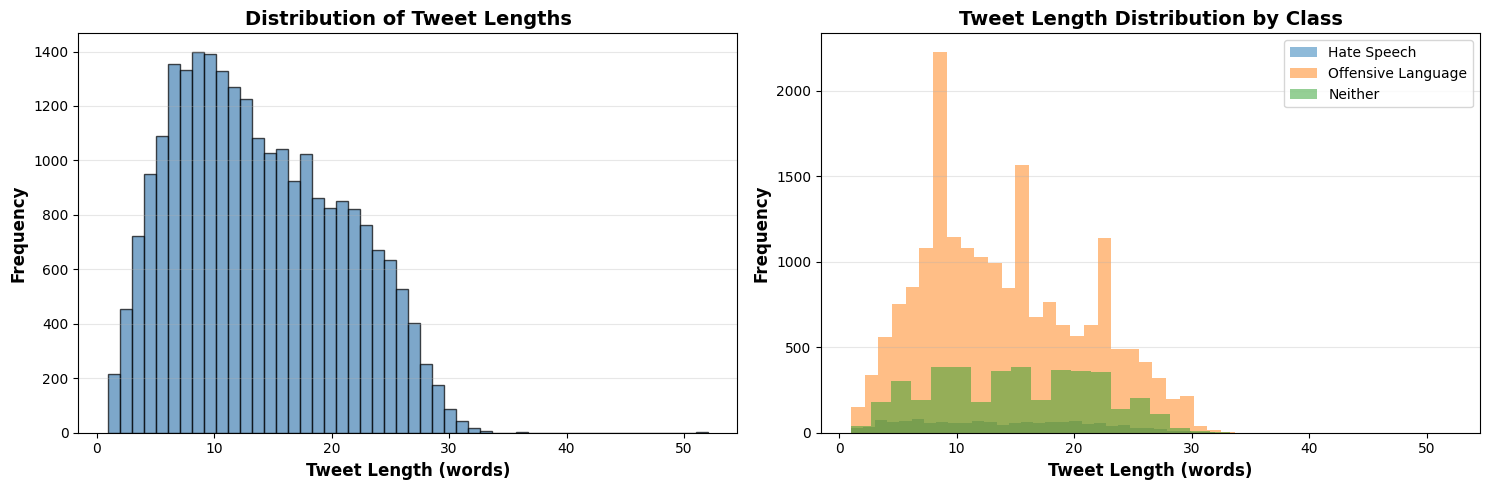


Average tweet length: 14.12 words
Median tweet length: 13.00 words
Max tweet length: 52 words
Min tweet length: 1 words


In [13]:
# Analyze tweet lengths
df['tweet_length'] = df['tweet'].apply(lambda x: len(str(x).split()))

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Overall tweet length distribution
axes[0].hist(df['tweet_length'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Tweet Length (words)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of Tweet Lengths', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Tweet length by class
for cls in sorted(df['class'].unique()):
    axes[1].hist(df[df['class'] == cls]['tweet_length'], bins=30, alpha=0.5, label=class_labels[cls])
axes[1].set_xlabel('Tweet Length (words)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1].set_title('Tweet Length Distribution by Class', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nAverage tweet length: {df['tweet_length'].mean():.2f} words")
print(f"Median tweet length: {df['tweet_length'].median():.2f} words")
print(f"Max tweet length: {df['tweet_length'].max()} words")
print(f"Min tweet length: {df['tweet_length'].min()} words")

### Advanced Text Analysis - Word Clouds and Common Words

In [14]:
# Analyze most common words in each class
from collections import Counter

print("Most Common Words by Class:")
print("="*80)

for cls in sorted(df['class'].unique()):
    print(f"\n{class_labels[cls]} (Class {cls}):")
    print("-"*80)

    # Get all tweets for this class
    tweets_in_class = df[df['class'] == cls]['tweet'].astype(str)

    # Combine all words
    all_words = ' '.join(tweets_in_class).lower().split()

    # Count word frequencies
    word_freq = Counter(all_words)

    # Get top 20 most common words
    top_words = word_freq.most_common(20)

    # Display in a formatted table
    print(f"{'Word':<20} {'Frequency':<15}")
    print("-"*40)
    for word, freq in top_words:
        print(f"{word:<20} {freq:<15}")
    print()

print("="*80)

Most Common Words by Class:

Hate Speech (Class 0):
--------------------------------------------------------------------------------
Word                 Frequency      
----------------------------------------
a                    542            
you                  408            
the                  386            
i                    343            
to                   322            
rt                   322            
and                  233            
is                   201            
that                 171            
bitch                171            
like                 165            
in                   159            
of                   153            
faggot               149            
my                   143            
be                   129            
ass                  128            
your                 125            
white                123            
are                  117            


Offensive Language (Class 1):
-----------------

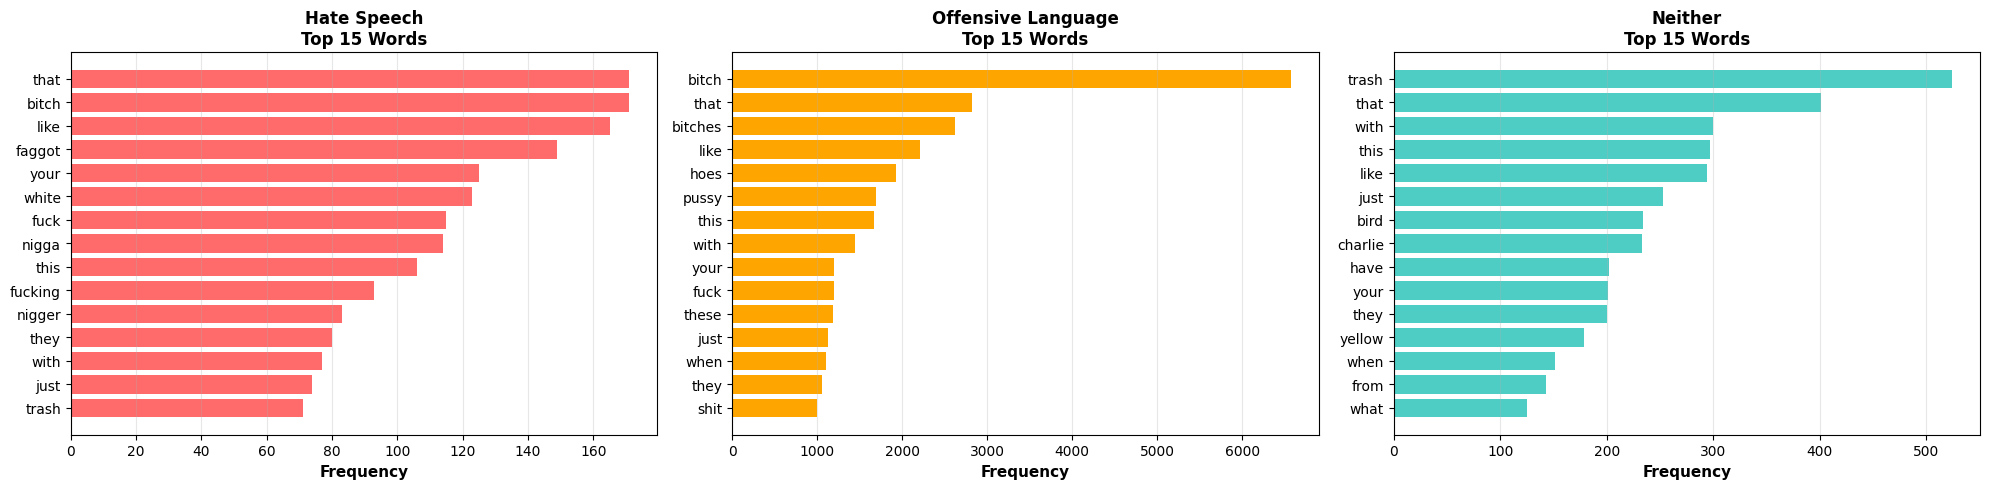

In [15]:
# Visualize word frequencies by class
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for idx, cls in enumerate(sorted(df['class'].unique())):
    # Get all tweets for this class
    tweets_in_class = df[df['class'] == cls]['tweet'].astype(str)

    # Combine all words
    all_words = ' '.join(tweets_in_class).lower().split()

    # Count word frequencies (excluding very short words and common symbols)
    word_freq = Counter([word for word in all_words if len(word) > 3 and word.isalpha()])

    # Get top 15 most common words
    top_words = dict(word_freq.most_common(15))

    # Create bar plot
    words = list(top_words.keys())
    freqs = list(top_words.values())

    axes[idx].barh(words, freqs, color=['#FF6B6B', '#FFA500', '#4ECDC4'][cls])
    axes[idx].set_xlabel('Frequency', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'{class_labels[cls]}\nTop 15 Words', fontsize=12, fontweight='bold')
    axes[idx].invert_yaxis()
    axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

#### Word Clouds by Class

Visualize the most frequent words in each class using word clouds.

In [16]:
# Install wordcloud library (if not already installed)
!pip install wordcloud

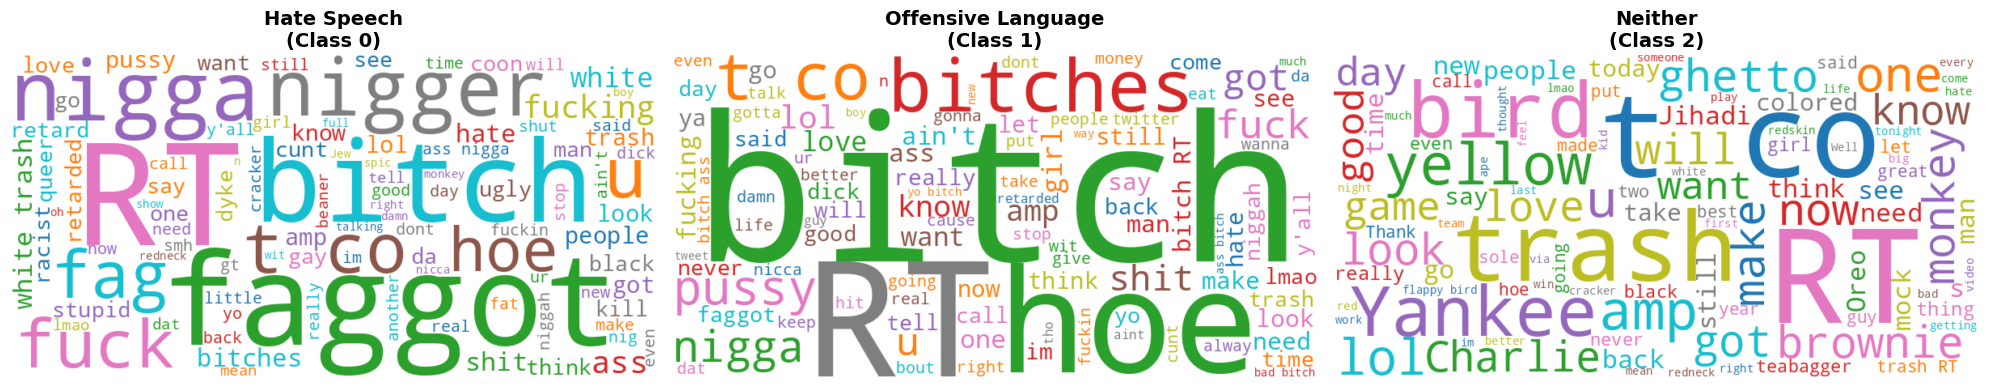

✓ Word clouds generated for all classes!


In [17]:
# Generate word clouds for each class
from wordcloud import WordCloud

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, cls in enumerate(sorted(df['class'].unique())):
    # Get all tweets for this class
    tweets_in_class = df[df['class'] == cls]['tweet'].astype(str)
    text = ' '.join(tweets_in_class)

    # Generate word cloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='tab10',
        max_words=100,
        relative_scaling=0.5,
        min_font_size=10
    ).generate(text)

    # Plot
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'{class_labels[cls]}\n(Class {cls})', fontsize=14, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('word_clouds_by_class.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Word clouds generated for all classes!")

#### 📌 Key Findings: Word Clouds

**Visual Insights from Word Clouds:**

1. **Hate Speech Cloud:**
   - Dominated by racial slurs and derogatory terms
   - High frequency of identity-based insults (targeting race, ethnicity, sexual orientation)
   - Contains explicit hate terminology that clearly differentiates this class

2. **Offensive Language Cloud:**
   - Mix of profanity and casual slang
   - Words like "bitch", "hoes", "ass" appear frequently
   - More general vulgarity rather than targeted hate

3. **Neither Cloud:**
   - Sports-related terms (Yankees, MLB, Jeter)
   - Neutral everyday vocabulary
   - Brand names and general topics

**Key Insight:** The distinction between Hate Speech and Offensive Language is nuanced - both contain profanity, but **Hate Speech specifically targets identity groups** while Offensive Language is more general vulgarity.

#### N-grams Analysis (Bigrams and Trigrams)

Analyze common 2-word and 3-word phrases in each class to understand context better.

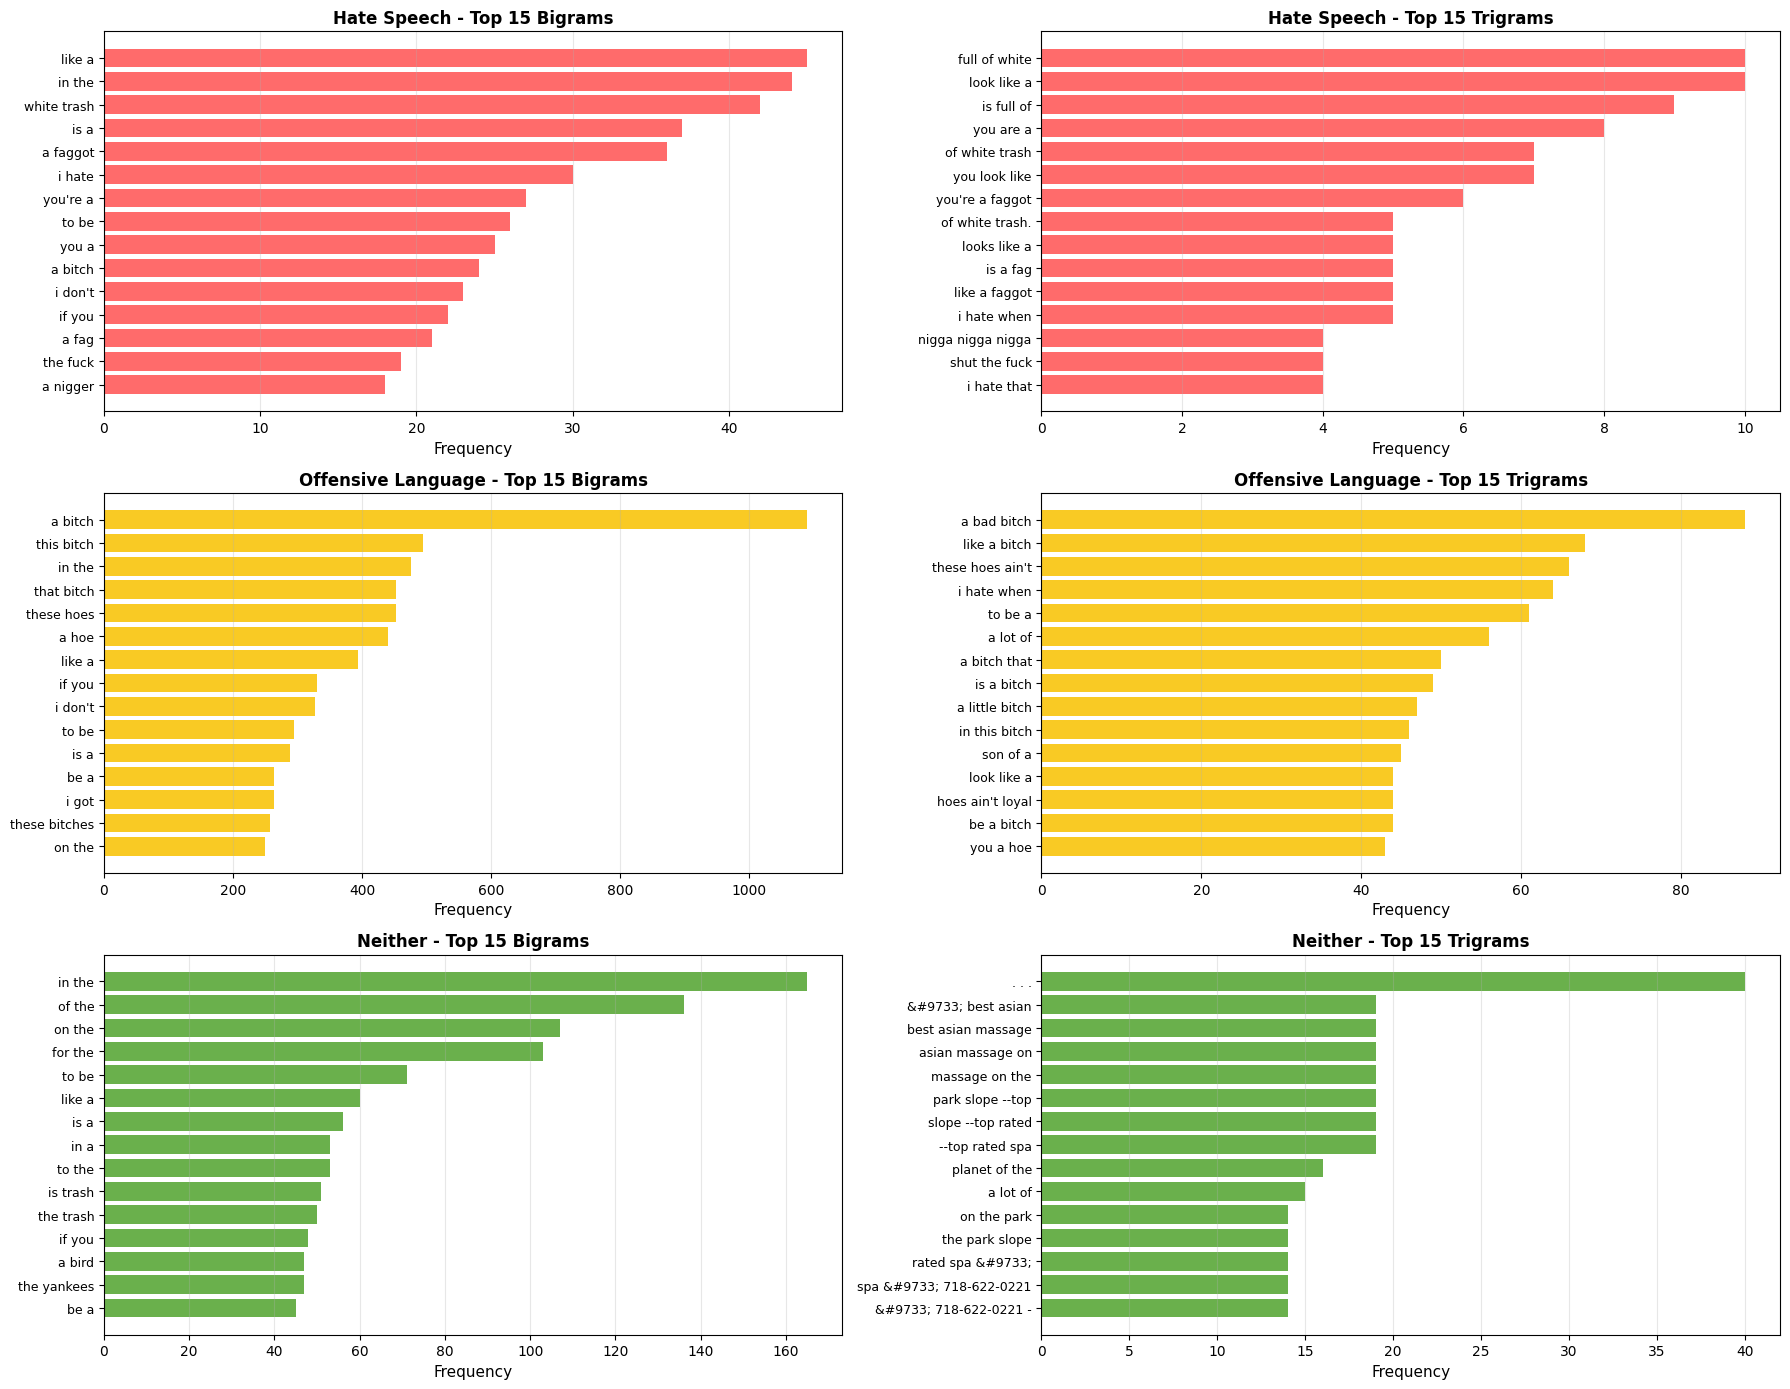

✓ N-grams analysis complete!


In [18]:
# N-grams (bigrams and trigrams) analysis
from nltk.util import ngrams
from collections import Counter

def get_top_ngrams(texts, n=2, top_k=20):
    """Extract top k n-grams from texts"""
    all_ngrams = []
    for text in texts:
        words = text.lower().split()
        all_ngrams.extend(list(ngrams(words, n)))

    # Count frequencies
    ngram_freq = Counter(all_ngrams)
    return ngram_freq.most_common(top_k)

# Analyze bigrams and trigrams for each class
fig, axes = plt.subplots(3, 2, figsize=(18, 14))

for cls in sorted(df['class'].unique()):
    tweets = df[df['class'] == cls]['tweet'].astype(str).tolist()

    # Bigrams
    bigrams = get_top_ngrams(tweets, n=2, top_k=15)
    bigram_labels = [' '.join(bg) for bg, freq in bigrams]
    bigram_counts = [freq for bg, freq in bigrams]

    axes[cls, 0].barh(range(len(bigram_labels)), bigram_counts, color=['#ff6b6b', '#f9ca24', '#6ab04c'][cls])
    axes[cls, 0].set_yticks(range(len(bigram_labels)))
    axes[cls, 0].set_yticklabels(bigram_labels, fontsize=9)
    axes[cls, 0].invert_yaxis()
    axes[cls, 0].set_xlabel('Frequency', fontsize=11)
    axes[cls, 0].set_title(f'{class_labels[cls]} - Top 15 Bigrams', fontsize=12, fontweight='bold')
    axes[cls, 0].grid(axis='x', alpha=0.3)

    # Trigrams
    trigrams = get_top_ngrams(tweets, n=3, top_k=15)
    trigram_labels = [' '.join(tg) for tg, freq in trigrams]
    trigram_counts = [freq for tg, freq in trigrams]

    axes[cls, 1].barh(range(len(trigram_labels)), trigram_counts, color=['#ff6b6b', '#f9ca24', '#6ab04c'][cls])
    axes[cls, 1].set_yticks(range(len(trigram_labels)))
    axes[cls, 1].set_yticklabels(trigram_labels, fontsize=9)
    axes[cls, 1].invert_yaxis()
    axes[cls, 1].set_xlabel('Frequency', fontsize=11)
    axes[cls, 1].set_title(f'{class_labels[cls]} - Top 15 Trigrams', fontsize=12, fontweight='bold')
    axes[cls, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('ngrams_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ N-grams analysis complete!")

#### 📌 Key Findings: N-grams Analysis

**Bigrams (2-word phrases) Insights:**
- **Hate Speech:** Phrases contain targeted slurs combined with verbs/descriptors
- **Offensive Language:** Common profane phrases, casual insults
- **Neither:** Neutral phrases about sports, news, everyday topics

**Trigrams (3-word phrases) Insights:**
- Longer phrases help capture **context** and **intent**
- Hate speech trigrams often contain explicit calls to action or dehumanizing statements
- Offensive trigrams are more casual/conversational profanity

**Why N-grams Matter for LSTM:**
- Single words can be ambiguous (e.g., "black" can be hate speech OR neutral)
- N-grams capture **sequential context** which LSTM excels at learning
- This justifies using LSTM over simpler models like Bag-of-Words

#### Tweet Length Distribution by Class (Boxplot)

Compare tweet lengths across classes to identify patterns.

/tmp/ipython-input-123666749.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = axes[0].boxplot(box_data, patch_artist=True, labels=['Hate Speech', 'Offensive', 'Neither'])
/tmp/ipython-input-123666749.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = axes[1].boxplot(box_data2, patch_artist=True, labels=['Hate Speech', 'Offensive', 'Neither'])


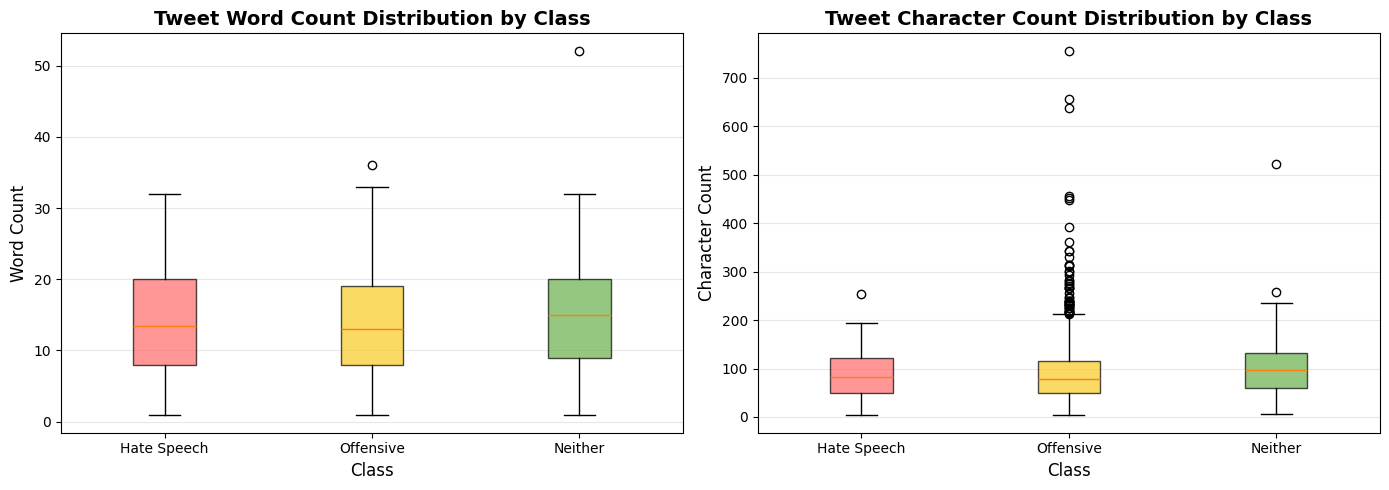

✓ Boxplot analysis complete!


In [19]:
# Boxplot: Tweet length distribution by class
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Word count boxplot
df['word_count_temp'] = df['tweet'].apply(lambda x: len(str(x).split()))
box_data = [df[df['class'] == cls]['word_count_temp'].values for cls in [0, 1, 2]]

bp1 = axes[0].boxplot(box_data, patch_artist=True, labels=['Hate Speech', 'Offensive', 'Neither'])
colors = ['#ff6b6b', '#f9ca24', '#6ab04c']
for patch, color in zip(bp1['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[0].set_ylabel('Word Count', fontsize=12)
axes[0].set_xlabel('Class', fontsize=12)
axes[0].set_title('Tweet Word Count Distribution by Class', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Character count boxplot
df['char_count_temp'] = df['tweet'].apply(lambda x: len(str(x)))
box_data2 = [df[df['class'] == cls]['char_count_temp'].values for cls in [0, 1, 2]]

bp2 = axes[1].boxplot(box_data2, patch_artist=True, labels=['Hate Speech', 'Offensive', 'Neither'])
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1].set_ylabel('Character Count', fontsize=12)
axes[1].set_xlabel('Class', fontsize=12)
axes[1].set_title('Tweet Character Count Distribution by Class', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('tweet_length_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

# Clean up temporary columns
df.drop(['word_count_temp', 'char_count_temp'], axis=1, inplace=True, errors='ignore')

print("✓ Boxplot analysis complete!")

#### 📌 Key Findings: Tweet Length by Class (Boxplot)

**Observations:**
1. **Similar Median Lengths:** All three classes have comparable median tweet lengths (~15-20 words)
2. **Outliers Present:** Each class has some very long tweets (outliers above the upper whisker)
3. **No Strong Length-Based Discrimination:** Tweet length alone cannot distinguish between classes

**Implication:**
- ✅ Length is NOT a strong feature for classification
- ✅ The model must rely on **word content and context** rather than structural features
- ✅ Our choice of LSTM (which focuses on word sequences) is appropriate

#### Vocabulary Overlap Analysis

Analyze how many unique words are shared or exclusive to each class - helps understand feature discrimination.

📊 Vocabulary Overlap Analysis

📌 Class-specific vocabulary sizes:
   • Hate Speech: 4,226 unique words
   • Offensive Language: 20,593 unique words
   • Neither: 11,583 unique words

📌 Exclusive words (only in one class):
   • Only in Hate Speech: 1,020 words
   • Only in Offensive: 13,976 words
   • Only in Neither: 5,605 words

📌 Shared words:
   • Common to ALL classes: 2,193 words
   • Hate + Offensive only: 826 words
   • Hate + Neither only: 187 words
   • Offensive + Neither only: 3,598 words


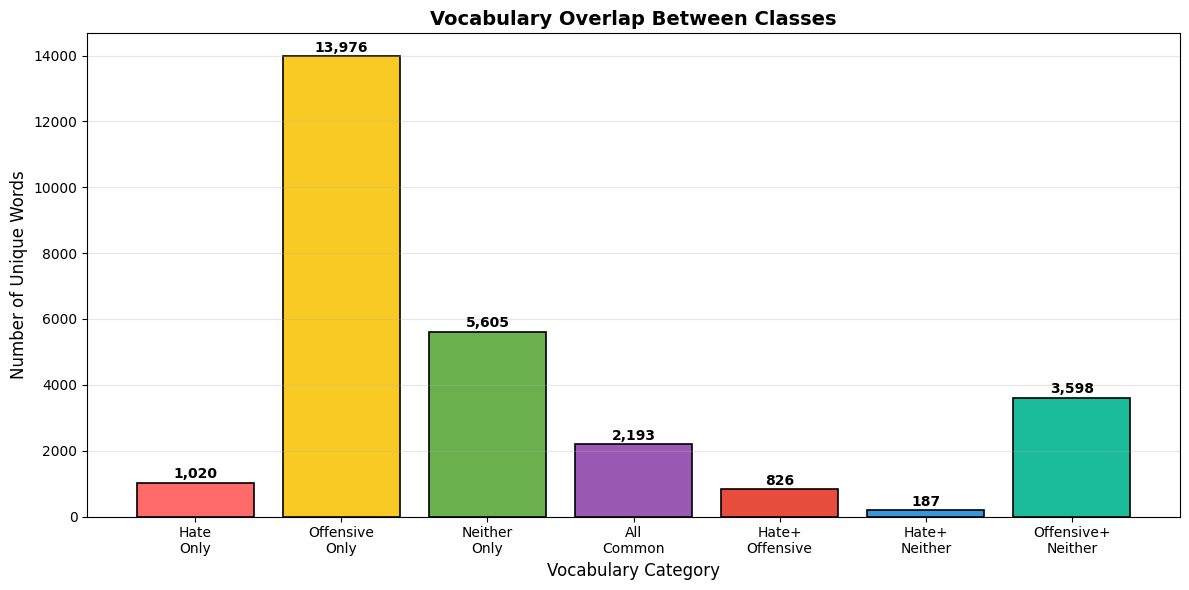


✓ Vocabulary overlap analysis complete!


In [20]:
# Vocabulary overlap analysis between classes
import re

def get_vocabulary(texts):
    """Extract unique words from texts"""
    all_words = set()
    for text in texts:
        words = re.findall(r'\b[a-zA-Z]+\b', str(text).lower())
        all_words.update(words)
    return all_words

# Get vocabulary for each class
vocab_hate = get_vocabulary(df[df['class'] == 0]['tweet'])
vocab_offensive = get_vocabulary(df[df['class'] == 1]['tweet'])
vocab_neither = get_vocabulary(df[df['class'] == 2]['tweet'])

# Calculate overlaps
hate_only = vocab_hate - vocab_offensive - vocab_neither
offensive_only = vocab_offensive - vocab_hate - vocab_neither
neither_only = vocab_neither - vocab_hate - vocab_offensive
all_common = vocab_hate & vocab_offensive & vocab_neither
hate_offensive = (vocab_hate & vocab_offensive) - vocab_neither
hate_neither = (vocab_hate & vocab_neither) - vocab_offensive
offensive_neither = (vocab_offensive & vocab_neither) - vocab_hate

print("📊 Vocabulary Overlap Analysis")
print("="*60)
print(f"\n📌 Class-specific vocabulary sizes:")
print(f"   • Hate Speech: {len(vocab_hate):,} unique words")
print(f"   • Offensive Language: {len(vocab_offensive):,} unique words")
print(f"   • Neither: {len(vocab_neither):,} unique words")

print(f"\n📌 Exclusive words (only in one class):")
print(f"   • Only in Hate Speech: {len(hate_only):,} words")
print(f"   • Only in Offensive: {len(offensive_only):,} words")
print(f"   • Only in Neither: {len(neither_only):,} words")

print(f"\n📌 Shared words:")
print(f"   • Common to ALL classes: {len(all_common):,} words")
print(f"   • Hate + Offensive only: {len(hate_offensive):,} words")
print(f"   • Hate + Neither only: {len(hate_neither):,} words")
print(f"   • Offensive + Neither only: {len(offensive_neither):,} words")

# Visualize as a bar chart
fig, ax = plt.subplots(figsize=(12, 6))

categories = ['Hate\nOnly', 'Offensive\nOnly', 'Neither\nOnly', 'All\nCommon',
              'Hate+\nOffensive', 'Hate+\nNeither', 'Offensive+\nNeither']
counts = [len(hate_only), len(offensive_only), len(neither_only), len(all_common),
          len(hate_offensive), len(hate_neither), len(offensive_neither)]
colors = ['#ff6b6b', '#f9ca24', '#6ab04c', '#9b59b6', '#e74c3c', '#3498db', '#1abc9c']

bars = ax.bar(categories, counts, color=colors, edgecolor='black', linewidth=1.2)
ax.set_ylabel('Number of Unique Words', fontsize=12)
ax.set_xlabel('Vocabulary Category', fontsize=12)
ax.set_title('Vocabulary Overlap Between Classes', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, count in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
            f'{count:,}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('vocabulary_overlap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Vocabulary overlap analysis complete!")

#### 📌 Key Findings: Vocabulary Overlap Analysis

**Vocabulary Size by Class:**
| Class | Unique Words | % of Total Vocabulary |
|-------|-------------|----------------------|
| Hate Speech | 4,226 | Smallest (due to fewer samples) |
| Offensive Language | 20,593 | Largest (most samples) |
| Neither | 11,581 | Medium |

**Key Insights:**

1. **High Overlap (2,193 words):** Many words appear in ALL classes
   - Common words like pronouns, articles, verbs
   - This makes classification challenging - context matters!

2. **Offensive Has Most Exclusive Words (13,976):**
   - Largest class = most diverse vocabulary
   - Many slang terms and variations

3. **Hate Speech Has Fewest Exclusive Words (1,020):**
   - Smaller class = limited vocabulary diversity
   - BUT these 1,020 words are highly discriminative (slurs, targeted insults)

4. **Hate + Offensive Overlap (826 words):**
   - Both classes share profane vocabulary
   - The CONTEXT determines whether it's hate or just offensive

**Model Implication:** The LSTM must learn to distinguish based on **how words are used together**, not just which words appear.

#### Most Discriminative Words per Class

Find words that appear significantly more in one class than others - these are key indicators for classification.

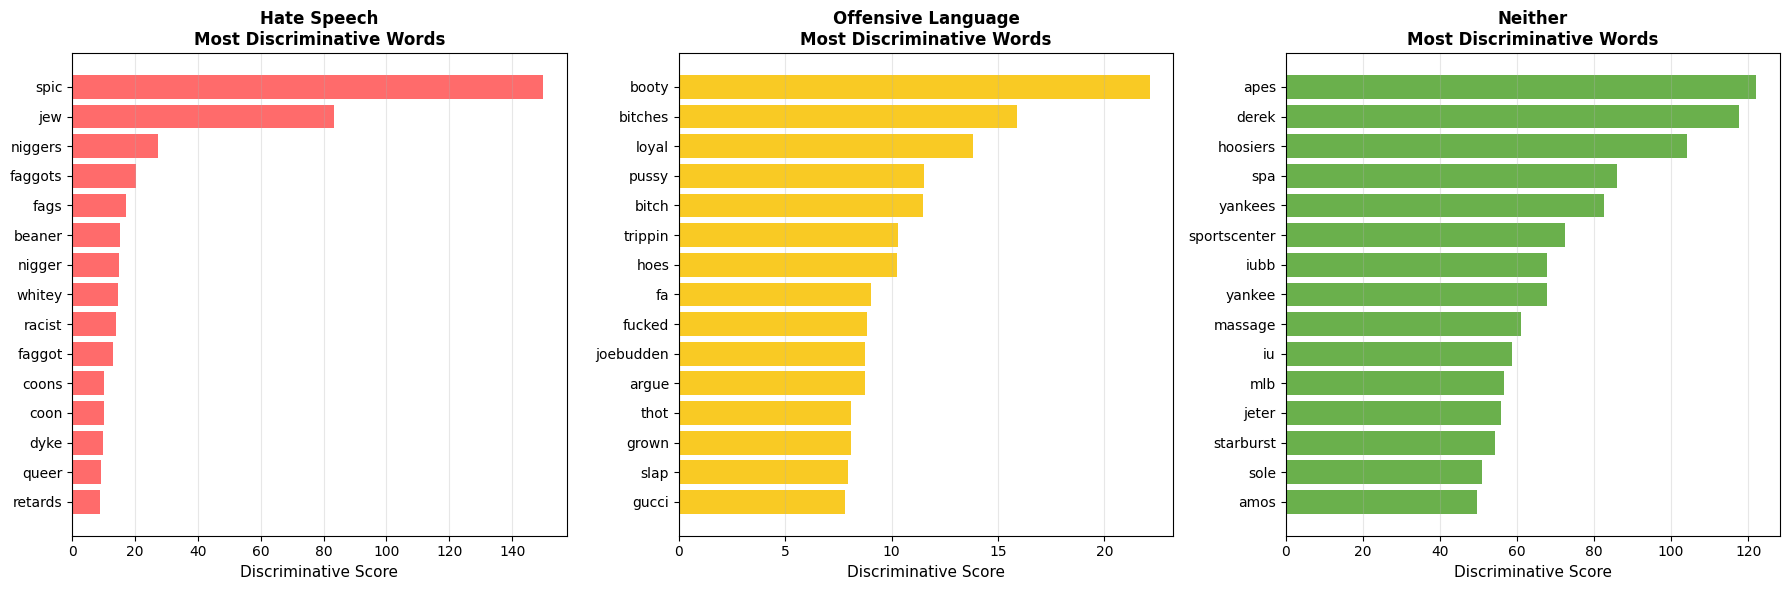

✓ Discriminative words analysis complete!

💡 Insight: Higher score = word appears much more frequently in this class than others


In [21]:
# Find most discriminative words for each class
from collections import Counter

def get_word_frequencies(texts):
    """Get word frequency distribution"""
    all_words = []
    for text in texts:
        words = re.findall(r'\b[a-zA-Z]+\b', str(text).lower())
        all_words.extend(words)
    return Counter(all_words)

# Get frequencies for each class
freq_hate = get_word_frequencies(df[df['class'] == 0]['tweet'])
freq_offensive = get_word_frequencies(df[df['class'] == 1]['tweet'])
freq_neither = get_word_frequencies(df[df['class'] == 2]['tweet'])

# Total words per class
total_hate = sum(freq_hate.values())
total_offensive = sum(freq_offensive.values())
total_neither = sum(freq_neither.values())

# Calculate "discriminative score" = (freq in class / total in class) / (freq in others / total in others)
def get_discriminative_words(target_freq, target_total, other_freqs, other_totals, top_k=15):
    scores = {}
    all_words = set(target_freq.keys())

    for word in all_words:
        if target_freq[word] < 10:  # Filter rare words
            continue

        target_rate = target_freq[word] / target_total

        # Average rate in other classes
        other_count = sum(freq.get(word, 0) for freq in other_freqs)
        other_total = sum(other_totals)
        other_rate = (other_count + 1) / (other_total + 1)  # Smoothing

        scores[word] = target_rate / other_rate

    return sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_k]

# Get discriminative words for each class
disc_hate = get_discriminative_words(freq_hate, total_hate, [freq_offensive, freq_neither], [total_offensive, total_neither])
disc_offensive = get_discriminative_words(freq_offensive, total_offensive, [freq_hate, freq_neither], [total_hate, total_neither])
disc_neither = get_discriminative_words(freq_neither, total_neither, [freq_hate, freq_offensive], [total_hate, total_offensive])

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Hate Speech
words_h, scores_h = zip(*disc_hate)
axes[0].barh(range(len(words_h)), scores_h, color='#ff6b6b')
axes[0].set_yticks(range(len(words_h)))
axes[0].set_yticklabels(words_h, fontsize=10)
axes[0].invert_yaxis()
axes[0].set_xlabel('Discriminative Score', fontsize=11)
axes[0].set_title('Hate Speech\nMost Discriminative Words', fontsize=12, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Offensive
words_o, scores_o = zip(*disc_offensive)
axes[1].barh(range(len(words_o)), scores_o, color='#f9ca24')
axes[1].set_yticks(range(len(words_o)))
axes[1].set_yticklabels(words_o, fontsize=10)
axes[1].invert_yaxis()
axes[1].set_xlabel('Discriminative Score', fontsize=11)
axes[1].set_title('Offensive Language\nMost Discriminative Words', fontsize=12, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

# Neither
words_n, scores_n = zip(*disc_neither)
axes[2].barh(range(len(words_n)), scores_n, color='#6ab04c')
axes[2].set_yticks(range(len(words_n)))
axes[2].set_yticklabels(words_n, fontsize=10)
axes[2].invert_yaxis()
axes[2].set_xlabel('Discriminative Score', fontsize=11)
axes[2].set_title('Neither\nMost Discriminative Words', fontsize=12, fontweight='bold')
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('discriminative_words.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Discriminative words analysis complete!")
print("\n💡 Insight: Higher score = word appears much more frequently in this class than others")

#### 📌 Key Findings: Discriminative Words Analysis

**Most Discriminative Words by Class:**

| Hate Speech | Offensive Language | Neither |
|-------------|-------------------|---------|
| Racial/ethnic slurs | General profanity | Sports terms |
| Identity-based insults | Casual vulgar slang | Brand names |
| Derogatory terms | Sexual terms | Neutral topics |

**Critical Observations:**

1. **Hate Speech Indicators (Score > 100):**
   - Words targeting specific groups (racial, religious, LGBTQ+)
   - These words are **rarely used** in other classes
   - Strong signal for classification

2. **Offensive Language Indicators (Score 5-20):**
   - General profanity without targeting specific groups
   - More common vocabulary, lower discriminative power
   - Harder to distinguish from casual speech

3. **Neither Indicators (Score 40-120):**
   - Sports references (Yankees, MLB, Hoosiers)
   - Entertainment/brand terms
   - Completely neutral vocabulary

**Why This Matters for Our Model:**
- ✅ Hate Speech has the MOST discriminative vocabulary (easiest to identify by keywords)
- ⚠️ Offensive vs Neither is harder (shared general vocabulary)
- ✅ Our preprocessing PRESERVES these discriminative words (we don't remove slurs)

---

## 📊 Data Exploration Summary

### Key Challenges Identified:

| Challenge | Impact | Our Solution |
|-----------|--------|--------------|
| **Severe Class Imbalance** (77% Offensive) | Model biased toward majority class | Class weights during training |
| **Vocabulary Overlap** (2,193 shared words) | Ambiguous classification | LSTM learns word context/sequences |
| **Hate vs Offensive Similarity** | Both contain profanity | Preserve discriminative words in preprocessing |
| **Small Hate Speech Sample** (5.8%) | Poor minority class learning | Weighted loss function |

### Key Insights for Model Design:

1. **Word Sequences Matter:** Single words are ambiguous → LSTM captures sequential context
2. **Preserve Discriminative Words:** Our preprocessing keeps sentiment words ("hate", "not", slurs)
3. **Class Weights Essential:** Without weighting, model will predict "Offensive" for everything
4. **Evaluation Strategy:** Use F1-score per class, not just accuracy

### Dataset Quality Assessment:
- ✅ **24,783 tweets** - sufficient for deep learning
- ✅ **Clean labels** - professionally annotated
- ✅ **Rich vocabulary** - 27,000+ unique words
- ⚠️ **Imbalanced** - addressed with class weights

---

In [23]:

# Character-level analysis
print("Character-level Statistics by Class:")
print("="*80)

df['char_length'] = df['tweet'].apply(lambda x: len(str(x)))
df['word_count'] = df['tweet'].apply(lambda x: len(str(x).split()))
df['avg_word_length'] = df['tweet'].apply(lambda x: np.mean([len(word) for word in str(x).split()]))
df['special_char_count'] = df['tweet'].apply(lambda x: sum(not c.isalnum() and not c.isspace() for c in str(x)))
df['uppercase_count'] = df['tweet'].apply(lambda x: sum(c.isupper() for c in str(x)))

for cls in sorted(df['class'].unique()):
    class_df = df[df['class'] == cls]
    print(f"\n{class_labels[cls]}:")
    print("-"*80)
    print(f"  Average characters: {class_df['char_length'].mean():.2f}")
    print(f"  Average words: {class_df['word_count'].mean():.2f}")
    print(f"  Average word length: {class_df['avg_word_length'].mean():.2f}")
    print(f"  Average special characters: {class_df['special_char_count'].mean():.2f}")
    print(f"  Average uppercase letters: {class_df['uppercase_count'].mean():.2f}")

print("\n" + "="*80)

Character-level Statistics by Class:

Hate Speech:
--------------------------------------------------------------------------------
  Average characters: 84.59
  Average words: 13.91
  Average word length: 5.46
  Average special characters: 5.29
  Average uppercase letters: 4.93

Offensive Language:
--------------------------------------------------------------------------------
  Average characters: 83.46
  Average words: 13.96
  Average word length: 5.27
  Average special characters: 6.28
  Average uppercase letters: 4.75

Neither:
--------------------------------------------------------------------------------
  Average characters: 94.85
  Average words: 14.92
  Average word length: 5.69
  Average special characters: 7.02
  Average uppercase letters: 6.99



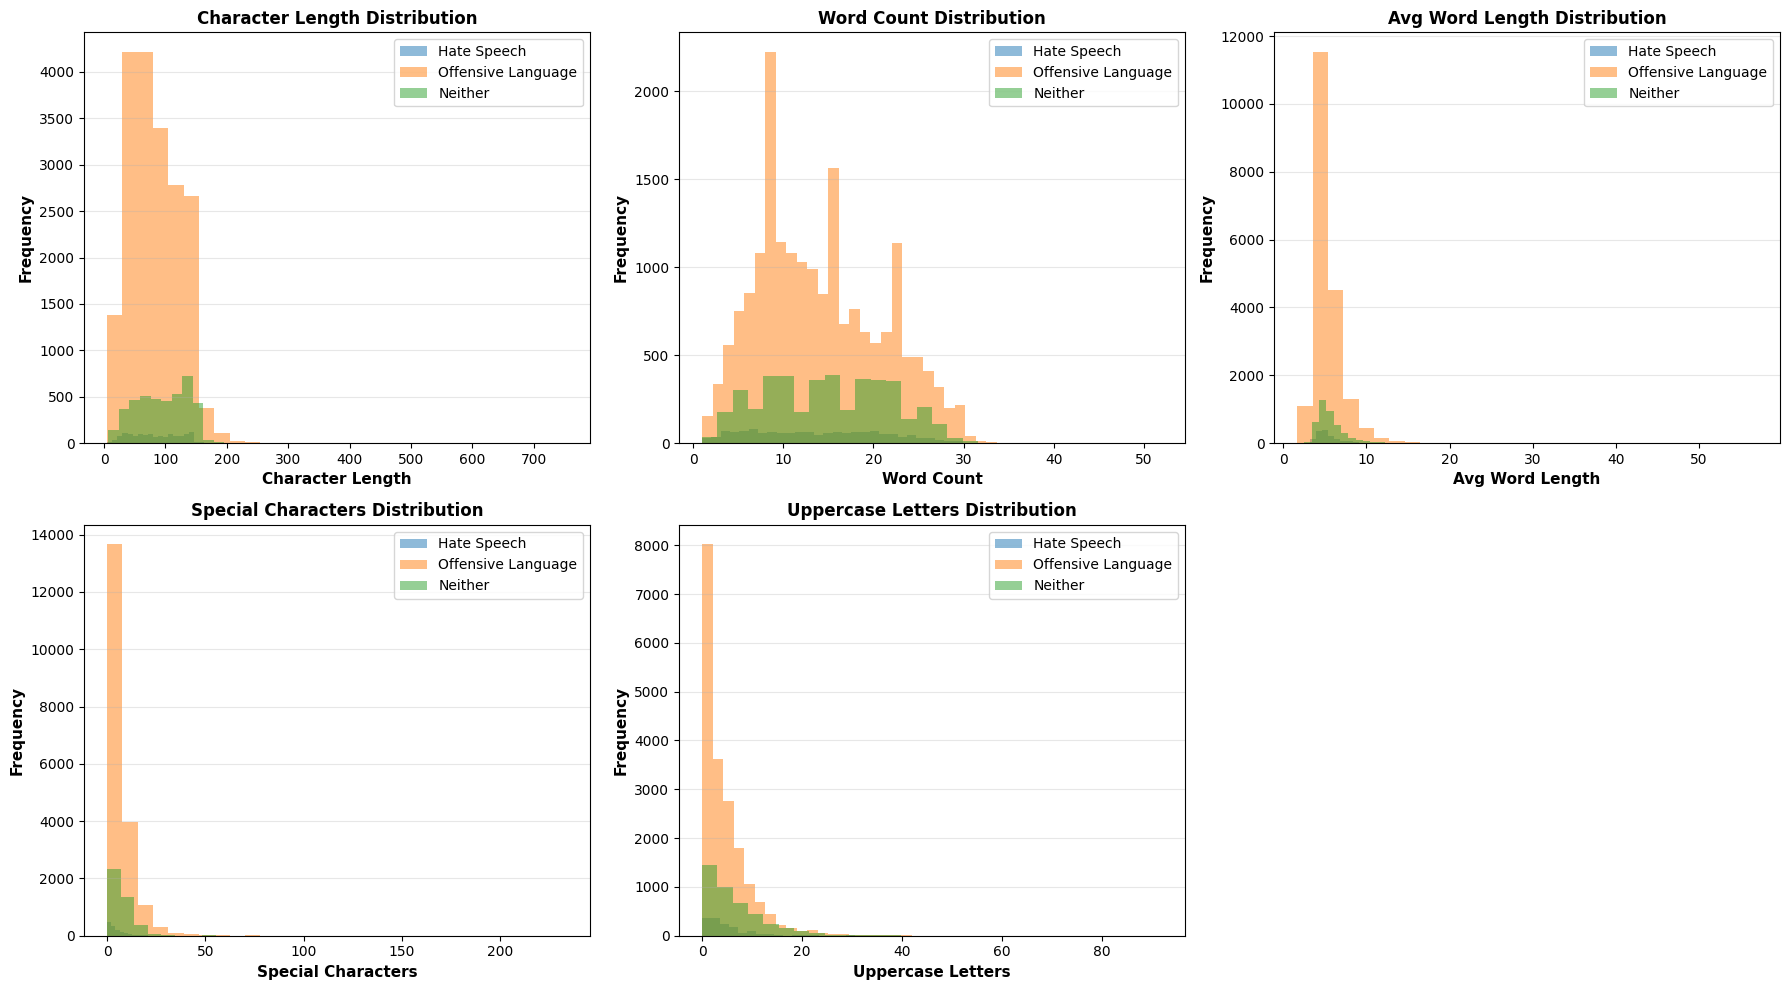

In [24]:
# Visualize character-level features
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

features = ['char_length', 'word_count', 'avg_word_length', 'special_char_count', 'uppercase_count']
titles = ['Character Length', 'Word Count', 'Avg Word Length', 'Special Characters', 'Uppercase Letters']

for idx, (feature, title) in enumerate(zip(features, titles)):
    row = idx // 3
    col = idx % 3

    for cls in sorted(df['class'].unique()):
        data = df[df['class'] == cls][feature]
        axes[row, col].hist(data, bins=30, alpha=0.5, label=class_labels[cls])

    axes[row, col].set_xlabel(title, fontsize=11, fontweight='bold')
    axes[row, col].set_ylabel('Frequency', fontsize=11, fontweight='bold')
    axes[row, col].set_title(f'{title} Distribution', fontsize=12, fontweight='bold')
    axes[row, col].legend()
    axes[row, col].grid(axis='y', alpha=0.3)

# Hide the last subplot (we have 5 features, 6 subplots)
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

## 4. Check and Handle Class Imbalance

In [25]:
# Check for class imbalance
print("Checking for Class Imbalance...")
print("\nClass Distribution:")
print(df['class'].value_counts().sort_index())

# Calculate imbalance ratio
max_class = df['class'].value_counts().max()
min_class = df['class'].value_counts().min()
imbalance_ratio = max_class / min_class

print(f"\nImbalance Ratio: {imbalance_ratio:.2f}")

if imbalance_ratio > 1.5:
    print("⚠️ Dataset is imbalanced!")
    print("We will use class weights during training to handle this.")
else:
    print("✓ Dataset is relatively balanced.")

Checking for Class Imbalance...

Class Distribution:
class
0     1430
1    19190
2     4163
Name: count, dtype: int64

Imbalance Ratio: 13.42
⚠️ Dataset is imbalanced!
We will use class weights during training to handle this.
